# Numerical solver for Schroedinger's equation.
## Numpy Update

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from cycler import cycler

%matplotlib inline

rc('text', usetex=True)
beta = 64 # beta = 2 m a^2 V0 / h^2

In [2]:
def potential(x):
    result = np.zeros_like(x)
    result[np.where(x > 0.5)] = 1.0
    return result

In [3]:
def shooting(initwave, initderiv, energy, x_axis):
    '''
    First function to be called when generating a new eigenfunction. Arguments are
    used to specify initial conditions, energy epsilon, and number of points
    (spacing)

    :param initwave: Initial value for the wavefunction
    :param initderiv: Initial value for the derivative
    :param energy: Value for the energy eigenvalue
    :param noofpoints: Number of points calculated
    '''
    # Initializing 3d array to store wave, derivatives, and position
    wave = np.zeros((2, x_axis.size))
    wave[0][0] = initwave
    wave[1][0] = initderiv
    # Calculate delta x based on number of points requested
    return generate(wave, x_axis, energy)

In [4]:
def generate(wave, xscale, energy):
    '''
    Function that is actually performing all the calculations for the new
    eigenfunction
    '''
    delta = xscale[1] - xscale[0]
    potential_arr = potential(xscale)

    for i in range(1, wave[0].size):
        # Equation 2 in code form
        wave[0][i] = wave[0][i - 1] + delta * wave[1][i - 1]
        # Equation 1 in code form
        wave[1][i] = wave[1][i - 1] - delta * beta * \
            (energy - potential_arr[i - 1]) * wave[0][i - 1]

    return wave[0]

In [5]:
def areaunder(wave, x_axis, xmax=0):
    '''
    Function that returns the area under the graph of a mathematical
    function passed as an argument. The area is calculated from x=0
    to x=xmax
    '''
    if xmax == 0:
        xmax = x_axis[-1]

    # Calculating the probability distribution of the wave
    y_val = probability(wave)
    area = 0
    for i in range(0, len(y_val) - 1):
        if x_axis[i] < xmax:
            # The middle value between to y data points is used
            area += (y_val[i] + (y_val[i + 1] - y_val[i]) / 2) * \
                (x_axis[i + 1] - x_axis[i])
    area = area * 2
    print("Area " + str(area))
    return area

In [6]:
def probability(wave):
    '''
    Function returning probability distribution for a given real wave function
    '''
    return wave * wave

In [7]:
def normalization(wave, x_axis):
    '''
    Function that returns normalized wave function by calculating overall probability
    and dividing the wave function by this normalization constant
    '''
    # TODO: automate xmax
    constant = 1 / math.sqrt(areaunder(wave, x_axis, 3))
    # List comprehension is used to divide all data points by the
    # constant = 1/K from Equation 5
    return wave * constant

In [13]:
def ploteigenfcs(x_axis, lines, title, file_name='', save=False):
    '''
    Plots three different functions onto one figure. Currently the color used are
    black, blue, red, magneto, cyan, and yellow
    '''
    # Get line to plot for potential energy V(x)
    energy_line = potential(x_axis)

    plt.figure()
    plt.rc('lines', linewidth=1.5)
    plt.rc('axes', prop_cycle=cycler(
        'color', ['k', 'b', 'r', 'g', 'm', 'c', 'y']))
    for desc, wave in lines.items():
        plt.plot(x_axis, wave, label=desc)

    plt.plot(x_axis, energy_line, label='potential')

    ymax = 0
    ymin = 0
    for wave in lines.values():
        ymax = np.maximum(np.amax(wave, axis=0), ymax)
        ymin = np.minimum(np.amin(wave, axis=0), ymin)
    plt.ylim(ymin-0.1, ymax+0.1)
    plt.xlim(0, 4)
    plt.xlabel(r'Radius $u=r/a_{0}$')
    plt.ylabel(r'Eigenfunction $\psi(u)$')
    plt.title(title, ha='center', fontsize=14)
    plt.legend()
    plt.grid()

    if save:
        plt.savefig('files/' + str(file_name) + '.eps', format='eps',
                    dpi=1000)  # Optional line: saves the plot as .eps file

In [9]:
def find_eigenenergies(accuracy, n_max):
    x_axis = np.linspace(0.0, 3.0, 6000)
    del_x = x_axis*2
    min_energy = 1/(beta*del_x**2) + potential(x_axis)
    min_index = np.argmin(min_energy)
    energy = min_energy[min_index]

    n = 0
    energies = []
    while n <= n_max:
        energy = find_eigenenergy(accuracy, energy, n)
        energies.append(energy)
        n += 1

    return energies

In [10]:
def find_eigenenergy(accuracy, energy, state):
    x_axis = np.linspace(0.0, 3.0, 6000)

    init_wave = 1.0
    init_der = 0.0
    if state % 2 == 1:
        init_wave = 0.0
        init_der = 1.0

    order = math.floor(math.log10(energy))
    energy = round(energy, -order)
    wave = shooting(init_wave, init_der, energy, x_axis)
    del_E = 10**order
    invert = 1.0
    if state % 4 > 1:
        invert = invert * -1.0
    factor = 1.0*invert

    while abs(wave[-1]) > np.amax(np.abs(wave)) * accuracy:
        if wave[-1] < 0:
            newfactor = -1.0
        else:
            newfactor = 1.0

        if newfactor != factor:
            del_E = 0.1 * del_E
        factor = newfactor
        energy = energy + invert*factor*del_E
        if energy > np.max(potential(x_axis)): # In this case we have unbound eigenstate
            return energy
        wave = shooting(init_wave, init_der, energy, x_axis)

    return energy

In [11]:
def numerical_slv():
    '''
    Executes the numerical solver script and generates plots
    '''
    energies = find_eigenenergies(0.1, 2) # Find first 3 bound eigenenergies

    x_axis = np.linspace(0.0, 3.0, 6000)
    eigenfc = shooting(1.0, 0, energies[0], x_axis)
    normalized = normalization(eigenfc, x_axis)
    eigenfc_exc = shooting(0.0, 1.0, energies[1], x_axis)
    normalized_exc = normalization(eigenfc_exc, x_axis)
    eigenfc_exc2 = shooting(1.0, 0.0, energies[2], x_axis)
    normalized_exc2 = normalization(eigenfc_exc2, x_axis)
    lines = {
        'Ground State': normalized,
        'First Excited': normalized_exc,
        'Second Excited': normalized_exc2
    }

    ploteigenfcs(x_axis, lines,
                 r'\textbf{Eigenfunctions vs Radial Distance}')
    plt.show()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


Area 0.63227882353
Area 0.0270206483143
Area 0.792325549714


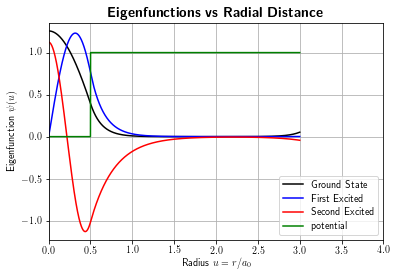

In [14]:
numerical_slv()